In [36]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
INTERVAL = np.array([-1., 1.])

In [8]:
def get_line(x1, y1, x2, y2):
    A = y2 - y1
    B = x1 - x2
    C = x2*y1 - x1*y2
    
    return np.array([C, A, B])

def get_points(n_points):
    return np.append(np.ones((n_points, 1)),
                     np.random.uniform(*INTERVAL, (n_points, 2)),
                     axis=1)

def label_points(X, w):
    return np.sign(np.dot(X, w))

def run_PLA(X, y_true):
    w_hat = np.zeros(3)
    
    for n_iter in itertools.count(start=1, step=1):
        clf_result = enumerate(label_points(X, w_hat) == y_true)
        misclassified_idx = [idx for idx, is_correct in clf_result if not is_correct]
        if not misclassified_idx:
            break
        rand_misclf_idx = np.random.choice(misclassified_idx)        
        w_hat = w_hat + y_true[rand_misclf_idx] * X[rand_misclf_idx]
        
    return w_hat, n_iter

def run_experiment(n_points=10, n_runs=1000, test_sample_size=1e5):
    print("Running PLA {0} times on a set of {1} points, evaluating on a set of {2:.0f} points."
          .format(n_runs, n_points, test_sample_size))
    
    n_iters = []
    disagrements = []_
    for i in range(n_runs):
        # Generate random line -- a target function
        support_points = np.random.uniform(*INTERVAL, 4)
        w_true = get_line(*support_points)
        
        # Generate points and classify them
        X_train = get_points(n_points)
        y_train_true = label_points(X_train, w_true)
        
        # Learn approximation function
        w_hat, n_iter = run_PLA(X_train, y_train_true)
        
        # Evaluate out-of-sample performance
        X_test = get_points(int(test_sample_size))
        y_test_true = label_points(X_test, w_true)
        y_pred = label_points(X_test, w_hat)
        disagreement = np.sum(y_test_true != y_pred) / test_sample_size
        
        n_iters.append(n_iter)
        disagrements.append(disagreement)
    
    print("Avg. iterations to converge: {:.1f}".format(np.mean(n_iters)))
    print("Avg. out-of-sample disagreement probability: {:.3f}".format(np.mean(disagrements)))

In [135]:
run_experiment()

Running PLA 1000 times on a set of 10 points, evaluating on a set of 100000 points.
Avg. iterations to converge: 10.6
Avg. out-of-sample disagreement probability: 0.106


In [136]:
run_experiment(n_points=100)

Running PLA 1000 times on a set of 100 points, evaluating on a set of 100000 points.
Avg. iterations to converge: 123.9
Avg. out-of-sample disagreement probability: 0.013


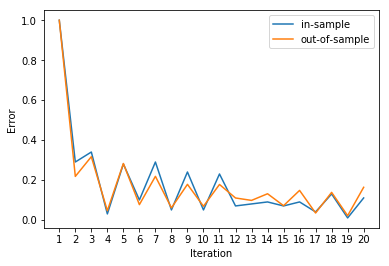

In [60]:
## Plotting in- vs out-of-sample errors for a PLA

# Setup
pop_size = int(1e6)
samp_size = 100
pla_iter = 20

# Get population and sample training set from it
pop = get_points(pop_size)
samp_idx = np.random.choice(pop_size, size=samp_size, replace=False)
sample = pop[samp_idx, :]

# Get true labels and labels of the training set
w_true = get_line(*np.random.uniform(*INTERVAL, 4))
y_true_pop = label_points(pop, w_true)
y_true_samp = y_true_pop[samp_idx]

# Run PLA and track in- and out-of-sample errors
Ein_evolution  = np.empty(pla_iter, dtype=np.float)
Eout_evolution = np.empty(pla_iter, dtype=np.float)
w_hat = np.zeros(3)
for i in range(pla_iter):    
    misclassified_samp = label_points(sample, w_hat) != y_true_samp
    misclassified_pop  = label_points(pop,    w_hat) != y_true_pop
    
    Ein_evolution[i]  = np.sum(misclassified_samp) / samp_size
    Eout_evolution[i] = np.sum(misclassified_pop)  / pop_size
    
    misclassified_idx = np.where(misclassified_samp)[0]
    if not misclassified_idx.size:
        break
    rand_misclf_idx = np.random.choice(misclassified_idx)        
    w_hat += y_true_samp[rand_misclf_idx] * sample[rand_misclf_idx]

# Plot tracked errors5
iter_num = range(1, pla_iter+1)
plt.plot(iter_num, Ein_evolution, label='in-sample')
plt.plot(iter_num, Eout_evolution, label='out-of-sample')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.xticks(iter_num)
plt.legend()
plt.show()